# Evaluation for Simulations of Murakami's On-Line Illusion (2003)

This file contains the motion detection stages, including the GMDN set up and creates the resulting plots. The input is provided by the spike time/position files created by running `ms_network_no_m.py`. The parameters for motion detection and properties of the global motion detection can all be varied with a simple rerun of cells, which allows for quick investigation of the resulting behaviour of the model data.

First, we evaluate the resulting values for varying the standard deviation $\sigma$ of FEM trajectories and fit a sigmoid curve. Then the motion detection stage of the actual simulations with different values of $(t_p, t_{on}$ is done. In the final part the respective value of $\sigma$ is obtained and plotted.

In [ ]:
import sys
import os
import glob
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm 
import cv2
import datetime
import itertools
import scipy.stats
from scipy import optimize
#import multiprocessing
from ms_functions import *

This is the sigmoid function and its inverse that we use to fit the data for varying $\sigma$.

In [2]:
def sigmoid_func(x, a, b, c):
    return a / (b + np.exp(-c*x))

def inv_sigmoid_func(y, a, b, c):
    return -1./c * np.log(a/y - b)

### Parameter

Here all parameters are set, except $\sigma_{min}$. Motion detectors are implemented by binning spikes and then comparing different bins in neighboring cells. 

- `t_full`: simulation time
- `t_bin`: interval length for binning in steps (1ms)
- `b_vels`: range of bins that get checked (including the upper limit). These are equivalent to velocity ranges for each bin, cf. [additional information](../../additional_info.ipynb)
- `n_gmdn`: the number of global motion detection neurons into which the simulated cells get divided in $x$- and $y$-direction, division into simple squares
- `npms`: number of neighboring cells that get checked for motion spikes, with the respective delay. For example 2 means that three cells in a row have to spikewith the respective delay fitted to motion velocity and direction.
- `gmd_thrs`: global motion detection threshold $N_g$ 
- `mo_det_thrs`: the minimum number of coincidence events for two intervals, 2 mean that in both cells at the given intervals two spikes must have been detected to spark a motion signal
- `nthr`: threshold for minimum number of intervals with motion signal $n_D$, set to zero.
- `md_num`: if `True`, the numbe rof motion detectors that fired during an interval will be contained in the result, otherwise the result for an intervla will be equal to 1, if any detector detected motion (simple presence of motion)
- `snums`: numbers of the included simulations
- `methods`: `"md_par"` means that the GMDNs are activated by parasol cells, `"md_md"` means by the respective motion detectors. Both can be simulated simultaneously.

In [ ]:
#time interval length for binning
t_bin = 15
#range of bins that get checked
b_vels = [3, 5]

#n_D is set to zero, sigma_min is used instead
nthr = 0.0

#parameters set for variying sigma
#range of sigma tested in percent of the normal value
std_max = 150
std_step = 25
stds = np.arange(0, std_max, std_step)


#this is the sqrt the number of gmdns used (so how many in one direction)
n_gmdns = np.asarray([1])

#set in percent
gmd_thrs = np.arange(1.0, 0.01, -0.1)

#set number of coincidence events per bin
mo_det_thrs = np.arange(0, 1, 1)

# simulation time
t_full = 1000

#time interval length for binning
t_bin = 15
#range of bins that get checked
b_vels = [3, 5]

#number of 
npms = 1

#this is the sqrt of the number of gmdns used (so how many in one direction)
n_gmdn = np.asarray([1])

#number of cells within RF firing accounted to global motion, set in cells
gmd_thrs = np.arange(20, 10, -1)

#number of coincidence events per bin
mo_det_thrs = np.arange(0, 1, 1)

#number of simulations
snums = np.arange(1, 7)

#number of 
md_num = False

methods = ["md_par", "md_md"]

#will contain results, clear here as well
diffs_sigma = {}

Set the cell grid, rest in next step (assign to GMDN).

In [ ]:
#set the grid, rest in next step
t_p = 53
t_off = 13
#file containing all parasol cell positions
gp_file = open('../../data/jitter_fem/1/zebra_std1_on'+str(t_p)+'off'+str(t_off)+'/p_pos_zebra_1_std1_on'+str(t_p)+'off'+str(t_off)+'.data', 'rb')
gp_data = np.load(gp_file)
gp_file.close()
#length = (36, 32)

#file containing all nodes
gid = open('../../data/jitter_fem/1/zebra_std1_on'+str(t_p)+'off'+str(t_off)+'/network/GID_info.txt', 'r+')
for l in gid:
    if 'parasols' in l.split('\t')[0].strip():
        first_node = int(l.split('\t')[1].strip())

### Simulation of Motion Detection Mechanism for Varying $\sigma$

Data will be stored in form of 

`diffs_sigma[(<GMDN input method>, <nr of GMDNs>, <global motion detection threshold>, <spike number motion detection threshold>, <simulation nr>, <standard deviation>)]`

In [32]:
#DIFFERENT STANDARD DEVIATIONS AND NUMBER OF MICROSACCADES

t_p = 107
t_offs = [0]
t_full = 856

for n_gmdn in n_gmdns:

    f_n = first_node
    n_pos = {}
    for q in gp_data:
        for p in gp_data[0]:
            n_pos[f_n] = (int(p[0]/(128./float(n_gmdn))), int(p[1]/(128./float(n_gmdn))))
            f_n += 1


    for thr in gmd_thrs:
        gmd_thr = int(thr * len(gp_data)/n_gmdn * len(gp_data[0])/n_gmdn) + 1 
        
        for md_thr in mo_det_thrs:
            
            print('GDMN Nr ' + str(n_gmdn) + ' (' + str(int(len(gp_data)*len(gp_data[0])/(n_gmdn*n_gmdn))) + 
                  ' cells) GMDN threshold ' + str(int(100.*thr)) + '% (' + str(gmd_thr) +
                  ' cells), motion threshold ' + str(md_thr) + ' spikes.')
                              
            for std in stds:

                for t_off in t_offs:
                    
                    for snum in snums:

                        ps = open('../../data/jitter_fem/'+ str(snum) +
                          '/zebra_std'+str(std)+'_on'+str(t_p)+'off'+str(t_off)+
                          '/network/spikes_parasols_zebra_'+str(snum)+'_std' + str(std) + '_on'+str(t_p)+'off'+str(t_off)+'.txt', 'r+')

                        pos = []
                        sp = []

                        sp_pos = {}
                        p = 0

                        #extract the spike times from file
                        for line in in_data[(snum, sname)]:
                            if len(line.split('[')) > 1:
                                p = int(line.split('[')[0])
                                spikes = line.split('[')[1]
                            if len(line.split(']')) > 0:
                                spikes = spikes.split(']')[0]

                            #convert spike times to bin numbers 
                            sp_n = []
                            for s in spikes.split(' '):
                                if len(s.strip()) > 0:
                                    pos += [p]
                                    sp += [float(s)]
                                    sp_n += [int((float(s)-0.01)/t_bin)]
                            #add position to 
                            sp_pos[p] = sp_n                        

                        in_data[(snum, sname)].close()


                        #store the number of parasol cells firing for each interval
                        bins_par_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))
                        bins_r_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))
                        bins_l_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))

                        #iterate through parasols
                        for key in sp_pos:

                            #to check the number of parasol cells spiking within one bin
                            did_spike = list(set(sp_pos[key]))
                            #get number of parasol cells spiking wihtin one bin
                            for d_s in did_spike:
                                if sp_pos[key].count(d_s) > md_thr:
                                    bins_par_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1

                            #get the number of motion detectors firing        
                            for d_s in did_spike:

                                #rightward motion
                                fs = []
                                for npm in range(npms):
                                    fs += [0]
                                    #if cell fired at least once during simulaton time
                                    if key - (npm + 1) in sp_pos:
                                        #check specific intervals
                                        for b_vel in range((npm  + 1) * b_vels[0], (npm  + 1) * b_vels[1] + 1):
                                            if (sp_pos[key].count(d_s) > md_thr and 
                                                sp_pos[key - (npm + 1)].count(d_s - b_vel) > md_thr):

                                                #set to 1, if 
                                                fs[npm] = 1

                                #leftward motion
                                fs_l = []
                                for npm in range(npms):
                                    fs_l += [0]
                                    if key + (npm + 1) in sp_pos:
                                        for b_vel in range((npm  + 1) * b_vels[0], (npm + 1) * b_vels[1] + 1):
                                            if (sp_pos[key].count(d_s) > md_thr and 
                                                sp_pos[key + (npm + 1)].count(d_s - b_vel) > md_thr):

                                                fs_l[npm] = 1

                                #if motion detectors in both directions simultaneously detect a motion signal 
                                #-> suppress
                                if 0 not in fs and 0 in fs_l:
                                    bins_r_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1

                                if 0 not in fs_l and 0 in fs:
                                    bins_l_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1



                        #GLOBAL MOTION DETECTION
                        gmdns_par = (bins_par_num < gmd_thr).astype(int)
                        gmdns_r = (bins_r_num < gmd_thr).astype(int)
                        gmdns_l = (bins_l_num < gmd_thr).astype(int)  


                        #if number of cells spiking in output
                        if md_num:
                            bins_par_on_gmd = bins_par_num  * gmdns_par
                            bins_r_on_gmd_par = bins_r_num * gmdns_par
                            bins_l_on_gmd_par = bins_l_num * gmdns_par
                            bins_r_on_gmd_r = bins_r_num * gmdns_r
                            bins_l_on_gmd_l = bins_l_num * gmdns_l

                        else:
                            bins_r_on_gmd_par = (bins_r_num > 0).astype(int) * gmdns_par
                            bins_l_on_gmd_par = (bins_l_num > 0).astype(int) * gmdns_par
                            bins_r_on_gmd_r = (bins_r_num > 0).astype(int) * gmdns_r
                            bins_l_on_gmd_l = (bins_l_num > 0).astype(int) * gmdns_l

                        #difference in leftward vs. rightward motion.
                        bins_lr_on_gmd_par = np.abs(bins_r_on_gmd_par - bins_l_on_gmd_par) 
                        bins_lr_on_gmd_each = np.abs(bins_r_on_gmd_r - bins_l_on_gmd_l)


                        #with several GMDNs, add data from each for each interval    
                        bins_lr_on_gmd_par = np.add.reduce(bins_lr_on_gmd_par, 0)    
                        bins_lr_on_gmd_par = np.add.reduce(bins_lr_on_gmd_par, 0)
                        bins_lr_on_gmd_each = np.add.reduce(bins_lr_on_gmd_each, 0)    
                        bins_lr_on_gmd_each = np.add.reduce(bins_lr_on_gmd_each, 0)


                        # save data for evaluation
                        diffs_sigma[("md_par", n_gmdn, gmd_thr, md_thr, snum, std)] = bins_lr_on_gmd_par
                        diffs_sigma[("md_md", n_gmdn ,gmd_thr, md_thr, snum, std)] = bins_lr_on_gmd_each

GDMN Nr 3 (26 cells) GMDN threshold 100% (27 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 90% (25 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 80% (22 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 70% (19 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 60% (17 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 50% (14 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 40% (11 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 30% (9 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 20% (6 cells), motion threshold 0 spikes.
GDMN Nr 3 (26 cells) GMDN threshold 10% (3 cells), motion threshold 0 spikes.
GDMN Nr 4 (15 cells) GMDN threshold 100% (16 cells), motion threshold 0 spikes.
GDMN Nr 4 (15 cells) GMDN threshold 90% (14 cells), motion threshold 0 spikes.
GDMN Nr 4 (15 cells) GMDN threshold 80% (13 cells), m

Next, we get the values and fit the sigmoid curves.

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion GMD Parasols
-----------------------------------------------------------------------------------------------------


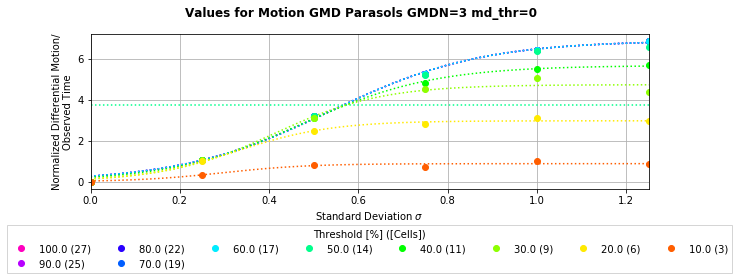

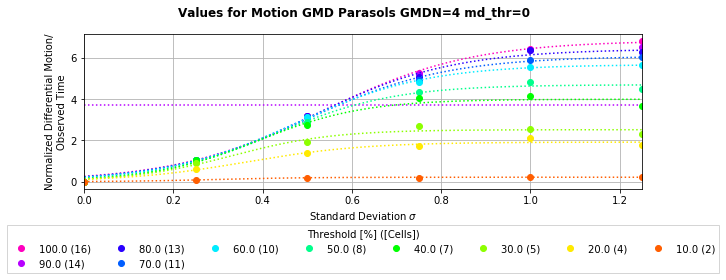

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion GMD Each
-----------------------------------------------------------------------------------------------------


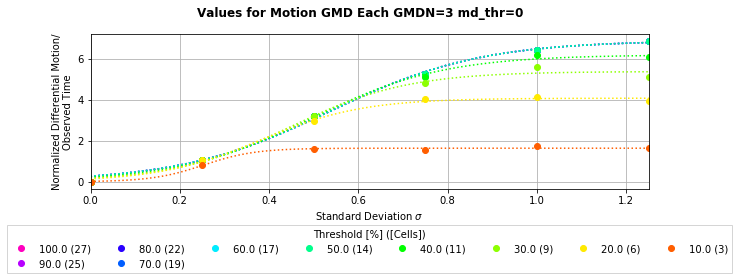

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

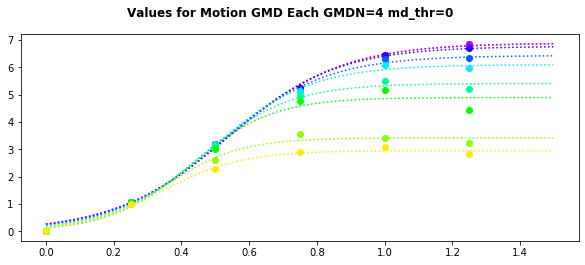

In [33]:
#the GMDN connections
methods = [("md_par", "Motion, Par")]
methods += [("md_md", "Motion, MD")]

#store fit parameters
fit_params = {}
fit_params_cov = {}

jitter_ampl_max = {}

for i, meth in enumerate(methods):

    print('-----------------------------------------------------------------------------------------------------')
    print('VALUES FOR ' + meth[1])
    print('-----------------------------------------------------------------------------------------------------')

    for md_thr in mo_det_thrs:
        
        for n_gmdn in n_gmdns:

            #plot integrals only during t_on for different t_p, for different methods

            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3.8), sharey=True)
            fig.suptitle(r'Values for ' + meth[1] + ' GMDN=' + str(n_gmdn) + ' md_thr=' + str(md_thr), weight='bold')

            res_effect = [[] for rg in range(len(gmd_thrs))]

            t_st = 214
            t_fin = 856
            t_fin = 636
            #norm = t_fin - t_st
            norm = int(t_fin/t_bin) - int(t_st/t_bin) + 1

            for gtk, thr in enumerate(gmd_thrs):
                
                res_effect[gtk] = np.zeros(shape=(len(stds)))

                for j, std in enumerate(stds):
                    
                    #get number of cells from percentage for N_g
                    gmd_thr = int(thr * len(gp_data)/n_gmdn * len(gp_data[0])/n_gmdn) + 1 

                    for snum in snums:
                        vals = copy.deepcopy(diffs_sigma[(meth[0], n_gmdn, gmd_thr, md_thr, snum, std)][int(t_st/t_bin):int(t_fin/t_bin)])

                        #get integrated difference only during t_on
                        for b in range(len(vals)):
                            if (b*t_bin)%t_p > (t_p-t_off):
                                vals[b] = 0.

                        res_effect[gtk][j] += sum(np.abs(vals))/norm
                        
                        if sum(np.abs(vals))/norm > nthr:
                            res_effect[gtk][j] += sum(np.abs(vals))/norm - nthr
                            
                    res_effect[gtk][j] /= len(snums)
                
                
                #fit curve
                params, params_cov = optimize.curve_fit(sigmoid_func, 0.01*stds, res_effect[gtk], p0=[1, 1, 1])

                fit_params[(meth[0], n_gmdn, gmd_thr)] = params
                fit_params_cov[(meth[0], n_gmdn, gmd_thr)] = params_cov
                
                #plot
                axes.plot(0.01*stds, res_effect[gtk], 'o',
                          color = cm.gist_rainbow((1.-float(gtk)/(float(len(gmd_thrs)+1) - 1.0))), 
                          label=str(round(100.*thr, 1)) + ' (' + str(gmd_thr) + ')')
                f_x =  np.arange(0, std_max, 0.01*std_step)
                axes.plot(0.01*f_x, sigmoid_func(0.01*f_x, params[0], params[1], params[2]), linestyle=':', 
                          color = cm.gist_rainbow((1.-float(gtk)/(float(len(gmd_thrs)+1) - 1.0))))

            axes.set_xlim([0, 0.01*stds[-1]])
            axes.set_xlabel(r'Standard Deviation $\sigma$')
            axes.set_ylabel('Normalized Differential Motion/\nObserved Time')
            axes.grid()

            box = axes.get_position()
            axes.set_position([box.x0, box.y0 + box.height * 0.25, box.width, 0.75 * box.height])

            axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, ncol=8, 
                           title='Threshold [%] ([Cells])')
            #plt.savefig('../../results/murakami2003/gmdn' + str(n_gmdn) + meth[1].replace(" ", "") + '_' + str(int(100.*min(gmd_thrs))) + '_' + str(int(100.*max(gmd_thrs))) + '.pdf')
            plt.show()

### Simulation of Motion Detection Mechanism for On-Line Illusion

Simulation numbers have to be set, otherwise analogous to upper simulations. Data will be stored in form of 

`diffs[(<GMDN input method>, <nr of GMDNs>, <global motion detection threshold>, <spike number motion detection threshold>, <simulation nr>, <standard deviation>)]`

In [ ]:
snums = np.arange(1, 11)

In [ ]:
#set the grid, rest in next step
t_p = 53
t_off = 13
#file containing all parasol cell positions
gp_file = open('../../data/jitter_fem/1/zebra_std1_on'+str(t_p)+'off'+str(t_off)+'/p_pos_zebra_1_std1_on'+str(t_p)+'off'+str(t_off)+'.data', 'rb')
gp_data = np.load(gp_file)
gp_file.close()
#length = (36, 32)

#file containing all nodes
gid = open('../../data/jitter_fem/1/zebra_std1_on'+str(t_p)+'off'+str(t_off)+'/network/GID_info.txt', 'r+')
for l in gid:
    if 'parasols' in l.split('\t')[0].strip():
        first_node = int(l.split('\t')[1].strip())

In [ ]:
#DIFFERENT STANDARD DEVIATIONS AND NUMBER OF MICROSACCADES
for n_gmdn in n_gmdns:

    f_n = first_node
    n_pos = {}
    for q in gp_data:
        for p in gp_data[0]:
            n_pos[f_n] = (int(p[0]/(128./float(n_gmdn))), int(p[1]/(128./float(n_gmdn))))
            f_n += 1

    for thr in gmd_thrs:
        gmd_thr = int(thr * len(gp_data)/n_gmdn * len(gp_data[0])/n_gmdn) + 1 
        
        for md_thr in mo_det_thrs:
            
            print('GDMN Nr ' + str(n_gmdn) + ' (' + str(int(len(gp_data)*len(gp_data[0])/(n_gmdn*n_gmdn))) + 
                  ' cells) GMDN threshold ' + str(int(100.*thr)) + '% (' + str(gmd_thr) +
                  ' cells), motion threshold ' + str(md_thr) + ' spikes.')
                              
            for std in stds:
                
                for t_p in (107, 213, 53):

                    #set specifics for each t_p
                    if t_p == 53:
                        t_offs = [13, 27, 40]
                        t_full = 636
                    if t_p == 107:
                        t_offs = [0, 13, 27, 40, 53, 67, 80, 93]
                        t_full = 856
                        if snum > 5:
                            t_full = 636
                        
                    if t_p == 213:
                        t_offs = [27, 53, 80, 107, 133, 160, 187]
                        t_full = 852
                        if snum > 5:
                            t_full = 636

                    for t_off in t_offs:

                        ps = open('../../data/jitter_fem/'+ str(snum) +
                          '/zebra_std1_on'+str(t_p)+'off'+str(t_off)+
                          '/network/spikes_parasols_zebra_'+str(snum)+'_std1_on'+str(t_p)+'off'+str(t_off)+'.txt', 'r+')

                        pos = []
                        sp = []

                        sp_pos = {}
                        p = 0

                        #extract the spike times from file
                        for line in in_data[(snum, sname)]:
                            if len(line.split('[')) > 1:
                                p = int(line.split('[')[0])
                                spikes = line.split('[')[1]
                            if len(line.split(']')) > 0:
                                spikes = spikes.split(']')[0]

                            #convert spike times to bin numbers 
                            sp_n = []
                            for s in spikes.split(' '):
                                if len(s.strip()) > 0:
                                    pos += [p]
                                    sp += [float(s)]
                                    sp_n += [int((float(s)-0.01)/t_bin)]
                            #add position to 
                            sp_pos[p] = sp_n                        

                        in_data[(snum, sname)].close()


                        #store the number of parasol cells firing for each interval
                        bins_par_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))
                        bins_r_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))
                        bins_l_num = np.zeros(shape=(1, 1, int(t_full/t_bin) + 1))

                        #iterate through parasols
                        for key in sp_pos:

                            #to check the number of parasol cells spiking within one bin
                            did_spike = list(set(sp_pos[key]))
                            #get number of parasol cells spiking wihtin one bin
                            for d_s in did_spike:
                                if sp_pos[key].count(d_s) > md_thr:
                                    bins_par_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1

                            #get the number of motion detectors firing        
                            for d_s in did_spike:

                                #rightward motion
                                fs = []
                                for npm in range(npms):
                                    fs += [0]
                                    #if cell fired at least once during simulaton time
                                    if key - (npm + 1) in sp_pos:
                                        #check specific intervals
                                        for b_vel in range((npm  + 1) * b_vels[0], (npm  + 1) * b_vels[1] + 1):
                                            if (sp_pos[key].count(d_s) > md_thr and 
                                                sp_pos[key - (npm + 1)].count(d_s - b_vel) > md_thr):

                                                #set to 1, if 
                                                fs[npm] = 1

                                #leftward motion
                                fs_l = []
                                for npm in range(npms):
                                    fs_l += [0]
                                    if key + (npm + 1) in sp_pos:
                                        for b_vel in range((npm  + 1) * b_vels[0], (npm + 1) * b_vels[1] + 1):
                                            if (sp_pos[key].count(d_s) > md_thr and 
                                                sp_pos[key + (npm + 1)].count(d_s - b_vel) > md_thr):

                                                fs_l[npm] = 1

                                #if motion detectors in both directions simultaneously detect a motion signal 
                                #-> suppress
                                if 0 not in fs and 0 in fs_l:
                                    bins_r_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1

                                if 0 not in fs_l and 0 in fs:
                                    bins_l_num[n_pos[key][0]][n_pos[key][1]][d_s] += 1



                        #GLOBAL MOTION DETECTION
                        gmdns_par = (bins_par_num < gmd_thr).astype(int)
                        gmdns_r = (bins_r_num < gmd_thr).astype(int)
                        gmdns_l = (bins_l_num < gmd_thr).astype(int)  


                        #if number of cells spiking in output
                        if md_num:
                            bins_par_on_gmd = bins_par_num  * gmdns_par
                            bins_r_on_gmd_par = bins_r_num * gmdns_par
                            bins_l_on_gmd_par = bins_l_num * gmdns_par
                            bins_r_on_gmd_r = bins_r_num * gmdns_r
                            bins_l_on_gmd_l = bins_l_num * gmdns_l

                        else:
                            bins_r_on_gmd_par = (bins_r_num > 0).astype(int) * gmdns_par
                            bins_l_on_gmd_par = (bins_l_num > 0).astype(int) * gmdns_par
                            bins_r_on_gmd_r = (bins_r_num > 0).astype(int) * gmdns_r
                            bins_l_on_gmd_l = (bins_l_num > 0).astype(int) * gmdns_l

                        #difference in leftward vs. rightward motion.
                        bins_lr_on_gmd_par = np.abs(bins_r_on_gmd_par - bins_l_on_gmd_par) 
                        bins_lr_on_gmd_each = np.abs(bins_r_on_gmd_r - bins_l_on_gmd_l)


                        #with several GMDNs, add data from each for each interval    
                        bins_lr_on_gmd_par = np.add.reduce(bins_lr_on_gmd_par, 0)    
                        bins_lr_on_gmd_par = np.add.reduce(bins_lr_on_gmd_par, 0)
                        bins_lr_on_gmd_each = np.add.reduce(bins_lr_on_gmd_each, 0)    
                        bins_lr_on_gmd_each = np.add.reduce(bins_lr_on_gmd_each, 0)


                        # save data for evaluation
                        diffs[("md_par", n_gmdn, gmd_thr, md_thr, snum, std)] = bins_lr_on_gmd_par
                        diffs[("md_md", n_gmdn ,gmd_thr, md_thr, snum, std)] = bins_lr_on_gmd_each

### Evaluation

Evaluation depending on detection threshold $\sigma_{min}$. It is set as fraction of the normal standard deviation $\sigma$.

In [ ]:
sigma_min = 0.2

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion GMD Parasols
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
N_GMDN 3 Motion GMD Parasols
-----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in log


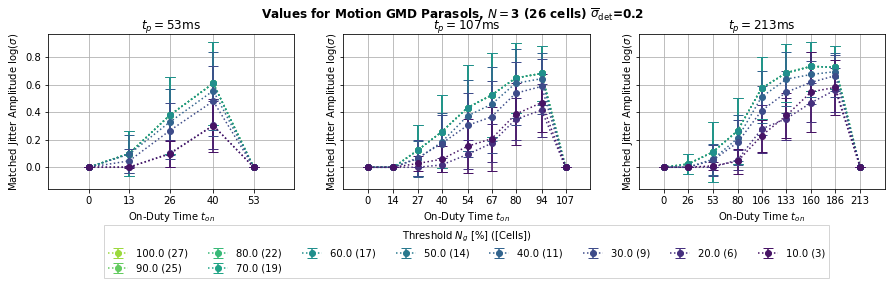

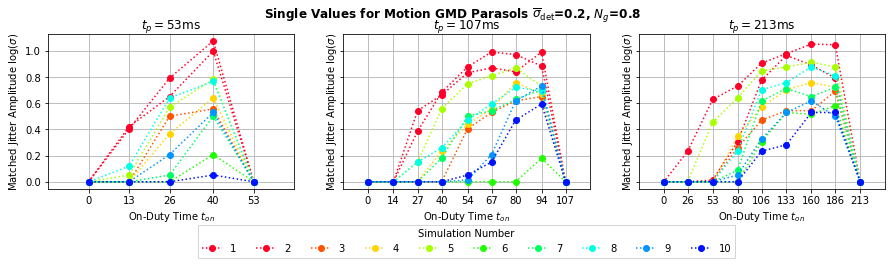

-----------------------------------------------------------------------------------------------------
N_GMDN 4 Motion GMD Parasols
-----------------------------------------------------------------------------------------------------


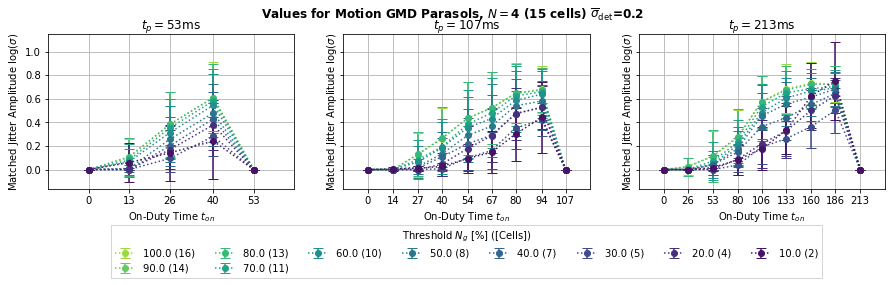

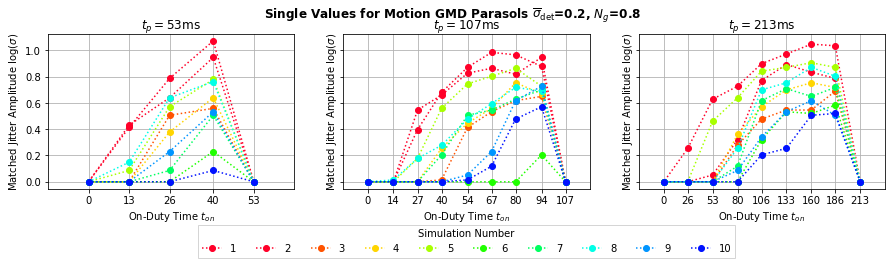

-----------------------------------------------------------------------------------------------------
VALUES FOR Motion GMD Each
-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------
N_GMDN 3 Motion GMD Each
-----------------------------------------------------------------------------------------------------


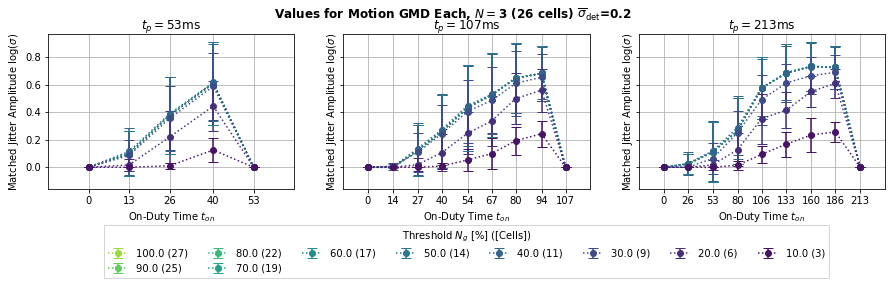

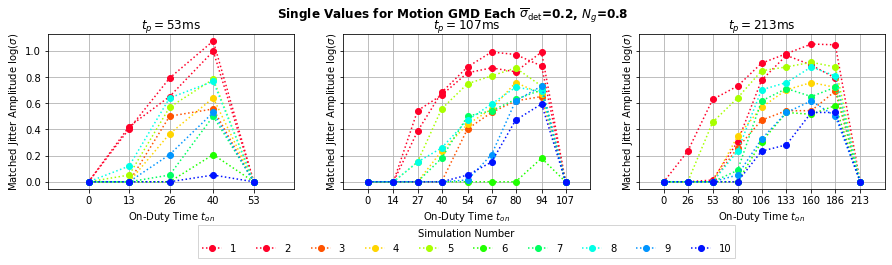

-----------------------------------------------------------------------------------------------------
N_GMDN 4 Motion GMD Each
-----------------------------------------------------------------------------------------------------


KeyError: ('Motion GMD Each', 4, 2)

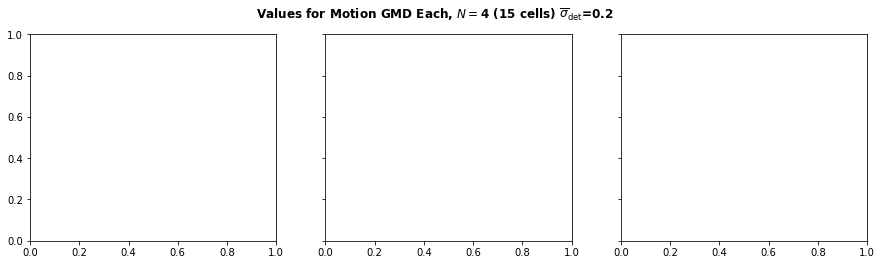

In [37]:
#the GMDN connections
methods = [("md_par", "Motion, Par")]
methods += [("md_md", "Motion, MD")]

for i, meth in enumerate(methods):

    print('-----------------------------------------------------------------------------------------------------')
    print('VALUES FOR ' + meth[1])
    print('-----------------------------------------------------------------------------------------------------')

    for md_thr in mo_det_thrs:
        
        for n_gmdn in n_gmdns:
            
            print('-----------------------------------------------------------------------------------------------------')
            print('N_GMDN ' + str(n_gmdn) + ' ' + meth[1])
            print('-----------------------------------------------------------------------------------------------------')

            #plot integrals only during t_on for different t_p, for different me'thods

            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.8), shwilll farley arey=True)
            fig.suptitle(r'Values for ' + meth[1] + ', $N=$' + str(n_gmdn) + ' ('
                         + str(int(len(gp_data)*len(gp_data[0])/(n_gmdn*n_gmdn))) + 
                         ' cells) $\overline{\sigma}_{\mathrm{det}}$=' + str(sigma_min), weight='bold')

            res_effect = [[[] for re in range(3)]for rg in range(len(gmd_thrs))]
            res_effect_err = [[[] for re in range(3)]for rg in range(len(gmd_thrs))]
            #to store values for single trajectories -> can be evaluated in next cell
            res_effect_sin = [[[[] for re in range(3)] for rs in range(len(snums))] for rg in range(len(gmd_thrs))]
            

            for j, t_p in enumerate([53, 107, 213]):

                #set specifics for each t_p
                #start after t_on > 210, to cut of intializing effects
                if t_p == 53:
                    t_off_vals = [0, 13, 27, 40, 53]
                    t_st = 212
                    t_fin = 636
                    #exp_vals = np.asarray([0, 0.7, 0.45, 0.23, 0])/1.5
                    
                if t_p == 107:
                    t_off_vals = [0, 13, 27, 40, 53, 67, 80, 93, 107]
                    t_st = 214
                    t_fin = 636
                    #exp_vals = np.asarray([0, 1.15, 1.5, 1.05, 0.62, 0.5, 0., 0., 0.])/1.5
                    
                if t_p == 213:
                    t_off_vals = [0, 27, 53, 80, 107, 133, 160, 187, 213]
                    t_st = 213
                    t_fin = 636
                    #exp_vals = np.asarray([0., 1.3, 1.4, 1.0, 0.75, 0.4, 0.2, 0., 0.])/1.5
                    
                norm = int(t_fin/t_bin) - int(t_st/t_bin) + 1
                

                t_on_vals = np.ones(len(t_off_vals))*t_p - t_off_vals

                for gtk, thr in enumerate(gmd_thrs):

                    gmd_thr = int(thr * len(gp_data)/n_gmdn * len(gp_data[0])/n_gmdn) + 1 
                    
                    #get minimum and maximum of fitted function
                    f_max = sigmoid_func(100, fit_params[(ats[i], n_gmdn, gmd_thr)][0], fit_params[(ats[i], n_gmdn, gmd_thr)][1], 
                                         fit_params[(ats[i], n_gmdn, gmd_thr)][2])
                    f_min = sigmoid_func(0, fit_params[(ats[i], n_gmdn, gmd_thr)][0], fit_params[(ats[i], n_gmdn, gmd_thr)][1], 
                                         fit_params[(ats[i], n_gmdn, gmd_thr)][2])
                    
                    
                    res_effect[gtk][j] = np.zeros(shape=(len(t_off_vals)), dtype=float)
                    for hi in range(len(snums)):
                        res_effect_sin[gtk][hi][j] = np.zeros(shape=(len(t_off_vals)), dtype=float)
                    res_effect_err[gtk][j] = np.zeros(shape=(len(t_off_vals)), dtype=float)

                    for q, t_off in enumerate(t_off_vals):
                        
                        h_arr = np.zeros(shape=(len(snums)), dtype=float)
                        
                        for snum in snums:
                        
                            if not t_off == t_p and not t_off == 0:

                                #first plot max diff (=min) parasols + integral parasols + integral only during t_on
                                vals = copy.deepcopy(diffs[(meth[0], n_gmdn, gmd_thr, md_thr, snum, t_p, t_off)][int(t_st/t_bin):int(t_fin/t_bin)])

                                # get integrated difference only during on times
                                for b in range(len(vals)):
                                    if (b*t_bin)%t_p > (t_p-t_off):
                                        vals[b] = 0.
                                       
                                if sum(np.abs(vals))/norm > nthr:
                                    
                                    h_val = sum(np.abs(vals))/norm - nthr
                                    
                                    #if current out of boundaries of comparison function, reset
                                    if sum(np.abs(vals))/norm - nthr >= f_max:
                                        h_val = f_max
                                    if sum(np.abs(vals))/norm - nthr <= f_min:
                                        h_val = 1.01*f_min
                                        qi = h_val
                                        
                                    #get value of sigma
                                    h_val = inv_sigmoid_func(h_val, fit_params[(meth[1], n_gmdn, gmd_thr)][0],
                                                             fit_params[(meth[1], n_gmdn, gmd_thr)][1],
                                                             fit_params[(meth[1], n_gmdn, gmd_thr)][2]
                                                            )/sigma_min
                                    if not h_val > 0:
                                        p = inv_sigmoid_func(qi, fit_params[(meth[1], n_gmdn, gmd_thr)][0],
                                                             fit_params[(meth[1], n_gmdn, gmd_thr)][1],
                                                             fit_params[(meth[1], n_gmdn, gmd_thr)][2]
                                                            )/sigma_min

                                    h_arr[snum - snums[0]] = np.log(h_val)
                                    
                                    if h_arr[snum - snums[0]] < 0: h_arr[snum - 1] = 0

                        for hi, ha in enumerate(h_arr):
                            res_effect_sin[gtk][hi][j][q] = ha
                        
                        res_effect[gtk][j][q] = np.mean(h_arr)
                        res_effect_err[gtk][j][q] = np.std(h_arr)

                        gmd_thr = int(thr * len(gp_data)/n_gmdn * len(gp_data[0])/n_gmdn) + 1                  
                        axes[j%3].errorbar(t_on_vals, res_effect[gtk][j], marker = 'o', linestyle=':', 
                                           yerr=res_effect_err[gtk][j], capsize=5,
                                           color = cm.viridis(1 - (0.8*float(gtk))/(float(len(gmd_thrs) - 1) + 0) - 0.15), 
                                           label=str(round(100.*thr, 1)) + ' (' + str(gmd_thr) + ')')


                #axes[j%3].plot(t_on_vals, exp_vals, color='red', linestyle='--', label="Experiment")
                axes[j%3].set_xlim([-t_off_vals[1], t_p + t_off_vals[1]])
                axes[j%3].set_xticks(t_on_vals)
                axes[j%3].set_xlabel(r'On-Duty Time $t_{on}$')
                axes[j%3].set_ylabel('Matched Jitter Amplitude $\log(\sigma)$')
                axes[j%3].grid()
                axes[j%3].set_title(r'$t_p=$' + str(t_p) + 'ms')
                
                box = axes[j%3].get_position()
                axes[j%3].set_position([box.x0, box.y0 + box.height * 0.25, box.width, 0.75 * box.height])

            axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, ncol=8, 
                           title='Threshold $N_g$ [%] ([Cells])')
            #plt.savefig('../../results/murakami2003/murakami-num-mj-time-' + meth[1].replace(" ", "") + 
            #           '-n-gmdn-' + str(n_gmdn) +
            #            '-ng-' + str(round(100.*min(gmd_thrs), 1)) + '-' 
            #            + str(round(100.*max(gmd_thrs), 1)) + '-nD-' + str(int(100.*det_thr_fr)) + '.pdf')
            plt.show()
            
            
            #'''#calculate pearson_r
            exp_data = np.asarray([0., 0.7, 0.45, 0.23, 0., 0., 1.15, 1.5, 1.05, 0.62, 0.5, 0., 0., 0.,
                                  0., 1.3, 1.4, 1.0, 0.75, 0.4, 0.2, 0., 0.])/1.5
            for gtk, thr in enumerate(gmd_thrs):
                sim_data = np.append(res_effect[gtk][0], res_effect[gtk][1])
                sim_data = np.append(sim_data, res_effect[gtk][2])
                p_r = scipy.stats.pearsonr(exp_data, sim_data)
                print(thr, p_r)
            #'''

Here you can see the values for singlle trajectories. Only works after last cell run. `plot_thr` sets the threshold $N_g$ you want to look at.

In [ ]:
plot_thr = 0.2

In [ ]:
for i, meth in enumerate(methods):

    print('-----------------------------------------------------------------------------------------------------')
    print('VALUES FOR ' + meth[1])
    print('-----------------------------------------------------------------------------------------------------')

    for md_thr in mo_det_thrs:
        
        for n_gmdn in n_gmdns:
            
            print('-----------------------------------------------------------------------------------------------------')
            print('N_GMDN ' + str(n_gmdn) + ' ' + meth[1])
            print('-----------------------------------------------------------------------------------------------------')

            for gtk, thr in enumerate(gmd_thrs):
                
                gmd_thr = int(thr * len(gp_data)/n_gmdn * len(gp_data[0])/n_gmdn) + 1
                
                if thr == plot_thr:
                    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.8), sharey=True)
                    fig.suptitle(r'Single Values for ' + meth[1] + ' $\overline{\sigma}_{\mathrm{det}}$=' 
                                 + str(det_thr_fr) + r', $N_g$=' + str(thr), weight='bold')


                    for j, t_p in enumerate([53, 107, 213]):

                        #set specifics for each t_p
                        if t_p == 53:
                            t_off_vals = [0, 13, 27, 40, 53]
                            t_st = 212
                            t_fin = 636
                            
                            #exp_vals = np.asarray([0, 0.7, 0.45, 0.23, 0])/1.5
                        if t_p == 107:
                            t_off_vals = [0, 13, 27, 40, 53, 67, 80, 93, 107]
                            t_st = 214
                            t_fin = 636

                            #exp_vals = np.asarray([0, 1.15, 1.5, 1.05, 0.62, 0.5, 0., 0., 0.])/1.5
                        if t_p == 213:
                            t_off_vals = [0, 27, 53, 80, 107, 133, 160, 187, 213]
                            t_st = 213
                            t_fin = 636
                            
                            #exp_vals = np.asarray([0., 1.3, 1.4, 1.0, 0.75, 0.4, 0.2, 0., 0.])/1.5
                            
                        norm = int(t_fin/t_bin) - int(t_st/t_bin) + 1

                        t_on_vals = np.ones(len(t_off_vals))*t_p - t_off_vals

                        for hi in range(int(len(snums))):                        
                            axes[j%3].plot(t_on_vals, res_effect_sin[gtk][hi][j], marker = 'o', linestyle=':', 
                                               color = cm.gist_rainbow((float(hi)/(float(len(snums) + 1) - 0.5)-0.1)),
                                               label=str(hi+1))


                        #axes[j%3].plot(t_on_vals, add_vals*rem, 'k:', label="Experiment")
                        axes[j%3].set_xlim([-t_off_vals[1], t_p + t_off_vals[1]])
                        axes[j%3].set_xticks(t_on_vals)
                        axes[j%3].set_xlabel(r'On-Duty Time $t_{on}$')
                        axes[j%3].set_ylabel('Matched Jitter Amplitude $\log(\sigma)$')
                        axes[j%3].grid()
                        axes[j%3].set_title(r'$t_p=$' + str(t_p) + 'ms')

                        box = axes[j%3].get_position()
                        axes[j%3].set_position([box.x0, box.y0 + box.height * 0.25, box.width, 0.75 * box.height])

                    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, ncol=10, 
                                   title='Simulation Number')
                    
                    #plt.savefig('../../results/murakami2003/murakami-num-mj-time-single-' + 
                    #            meth[1].replace(" ", "") + 
                    #            '-n-gmdn-' + str(n_gmdn) + '-ng-' + 
                    #            str(round(100*thr, 1)) + '-nD-' + str(int(100.*det_thr_fr)) + '.pdf')
                    plt.show()

